In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data, io, color


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

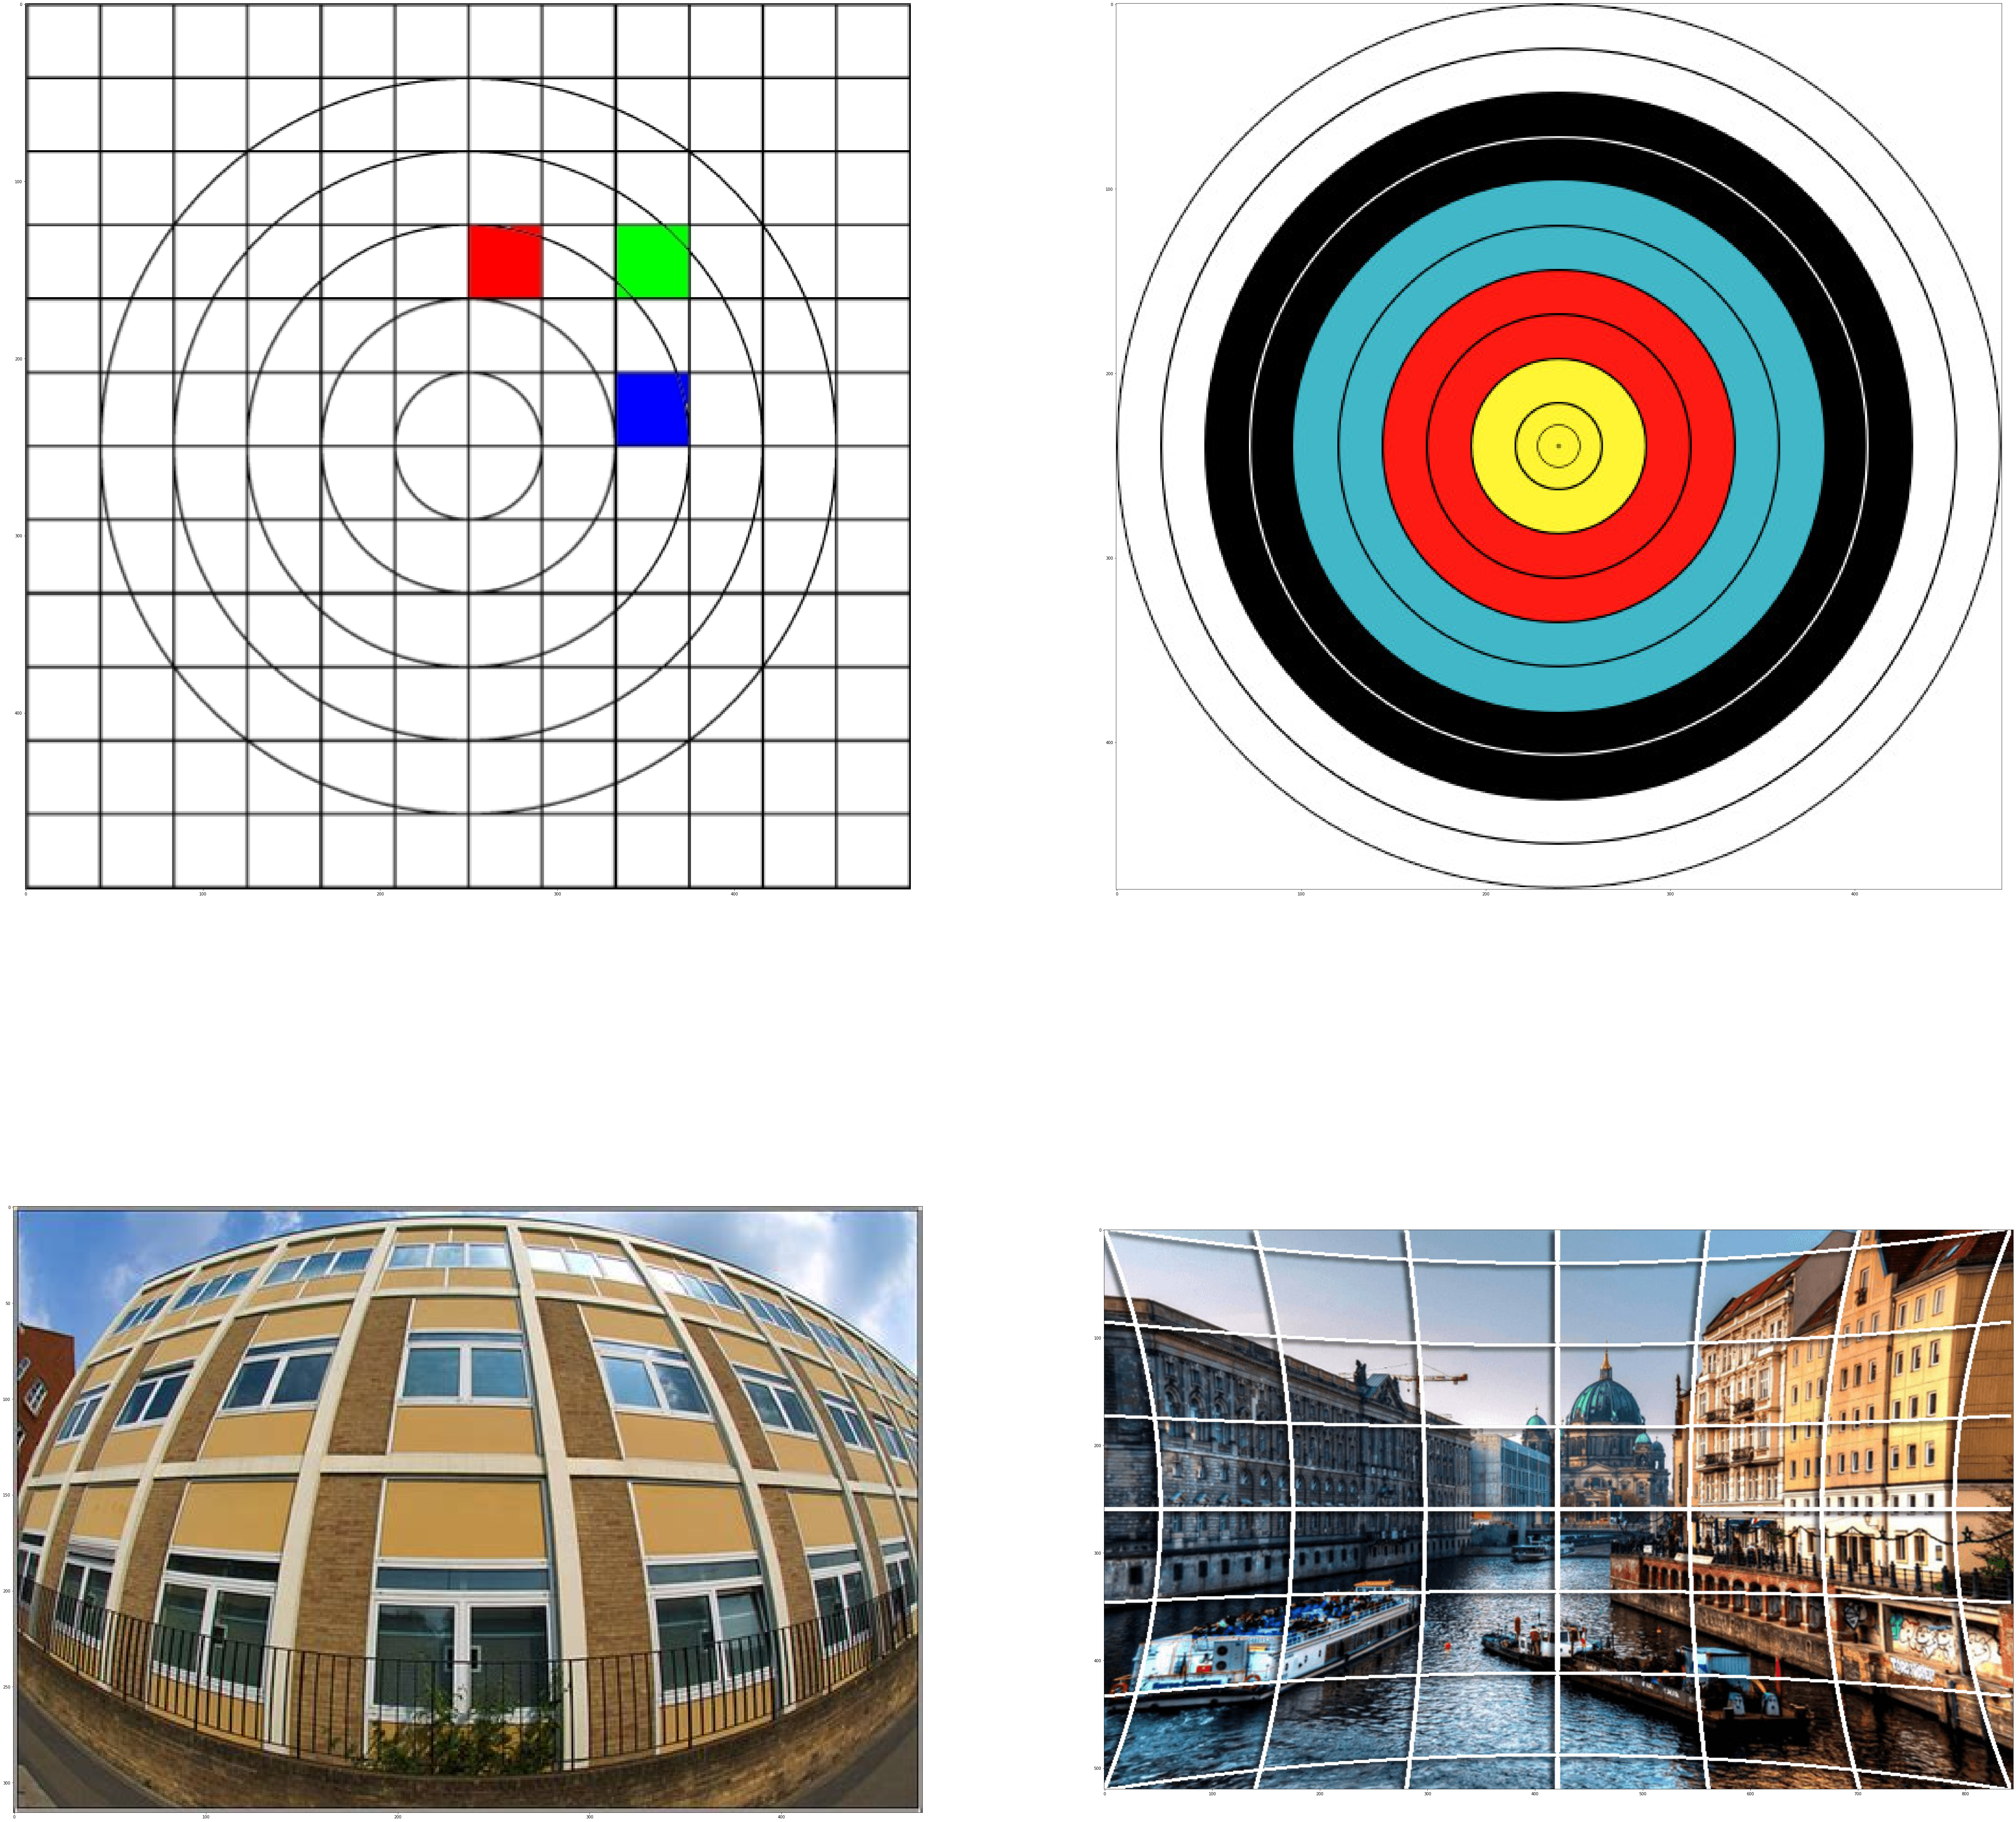

In [2]:
img = io.imread('test_grid.jpg')
target = io.imread('target.jpg')
house = io.imread('dist_house.jpg')
pin = io.imread('pincussion.jpg')

#img = color.rgb2gray(rgb_img)
plt.figure(figsize=(90,90))
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(target)
plt.subplot(2,2,3)
plt.imshow(house)
plt.subplot(2,2,4)
plt.imshow(pin)

In [3]:
# t array 2D
def translate(image, t):
    width,height=image.shape[:2]   
    dst = np.zeros((width*2, height*2, 3), dtype=np.uint8)
    # INVERSE MAPPING Loop over the destination, not the source, to ensure that you cover
    # every destination pixel exactly 1 time.
    for u in range(width):
        for v in range(height):
            x = u-t[0]
            y = v-t[1]
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            #interp = fracx*fracy + (1-fracx)*fracy + fracx*(1-fracy) + (1-fracx)*(1-fracy)
            if 0 < x < width-1 and 0 < y < height-1:
               #dst[u, v] = image[intx, inty] # qui tronco
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

In [4]:
def rotation2(image, angle):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    # INVERSE MAPPING Loop over the destination, not the source, to ensure that you cover
    # every destination pixel exactly 1 time.
    for u in range(width):
        for v in range(height):
            x = u*np.cos(-angle)+ v*np.sin(-angle)
            y = -u*np.sin(-angle)+v*np.cos(-angle)
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                #dst[u, v] = image[intx, inty] # qui tronco
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

In [5]:
def rotationCenter(image, angle):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    # INVERSE MAPPING Loop over the destination, not the source, to ensure that you cover
    # every destination pixel exactly 1 time.
    for u in range(width):
        for v in range(height):
            #traslate
            x1 = u-width/2
            y1 = v-height/2
            #rotate
            x2 = x1*np.cos(-angle)+ y1*np.sin(-angle)
            y2 = -x1*np.sin(-angle)+y1*np.cos(-angle)
            #traslate
            x = x2+width/2
            y = y2+height/2
            
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                #dst[u, v] = image[intx, inty] # qui tronco
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

In [6]:
# Prende un'immagine e applica la distorisone "barrel" partendo dal punto definito da wpx e wpy con fattori rf1 e rf2
def barrelDist(image,wpx,wpy,scale,rf1,rf2):
    width,height=image.shape[:2]
    print(width,height)
    if  (wpx > width or wpx < 0) or (wpy > height or wpy < 0):
        print("Punto non valido")
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    # INVERSE MAPPING Loop over the destination, not the source, to ensure that you cover
    # every destination pixel exactly 1 time.
    
    for u in range(width):
        for v in range(height):
            
            x1 = u-wpx
            y1 = v-wpy
            
            x2 = 2*x1 / width
            y2 = 2*y1 / height
            
            x2 /= scale
            y2 /= scale
            
            r = np.sqrt(x2**2 + y2**2)
            #r = np.sqrt(r)+rfactor
            r = 1 + rf1*r + rf2*r
            
            #phi = np.arctan2(y2,x2)
            
            #x3 = r*np.cos(phi)
            #y3 = r*np.sin(phi)
            
            x3 = x2 * r
            y3 = y2 * r
            
            x = x3+wpx
            y = y3+wpy

            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            #interp = fracx*fracy + (1-fracx)*fracy + fracx*(1-fracy) + (1-fracx)*(1-fracy)
            if 0 < x < width-1 and 0 < y < height-1:
                #dst[u, v] = image[intx, inty] # qui tronco
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

In [7]:
def cart2pol(x,y):
    theta = np.arctan2(y,x)
    rho = np.sqrt(x**2 + y**2)
    return (theta, rho)

In [8]:
def pol2cart(theta,rho):
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    return (x, y)

In [9]:
# t array 2D
def barrelDistCenterB(image,scale,rf):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    # INVERSE MAPPING Loop over the destination, not the source, to ensure that you cover
    # every destination pixel exactly 1 time.
    for u in range(width):
        for v in range(height):
            
            x1 = u-width/2
            y1 = v-height/2
            
            #x2 = 2*x1 / width
            #y2 = 2*y1 / height
            
            #x2 /= scale
            #y2 /= scale
            
            
            theta,r = cart2pol(x2,y2)

            R = np.sqrt((width/2)**2 + (height/2)**2)
            r = r/R
            #r = np.linalg.norm(x2**2,y2)
            #r = np.sqrt(r)+rfactor
            x3 = r*(1 + rf*(r**2))
            y3 = r*(1 + rf*(r**2))
            
            x4 = x3 * R
            y4 = y3 * R
            #theta = theta * (np.pi/180)
            x5,y5 = pol2cart(theta,r)
            
            x = x5+width/2
            y = y5+height/2

            #https://www.mathworks.com/matlabcentral/fileexchange/37980-barrel-and-pincushion-lens-distortion-correction
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            #interp = fracx*fracy + (1-fracx)*fracy + fracx*(1-fracy) + (1-fracx)*(1-fracy)
            if 0 < x < width-1 and 0 < y < height-1:
                #dst[u, v] = image[intx, inty] # qui tronco
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

fonti:
- https://www.mathworks.com/matlabcentral/fileexchange/37980-barrel-and-pincushion-lens-distortion-correction


- wikipedia  
    


In [19]:
# Prende un'immagine e applica la distorisone "barrel" partendo dal punto definito da wpx e wpy con fattori rf1 e rf2


def barrelDistCenter(image,scale,rf):
    width,height=image.shape[:2]
    
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    # INVERSE MAPPING Loop over the destination, not the source, to ensure that you cover
    # every destination pixel exactly 1 time.
    #distanza dal centro
    R = np.sqrt((width/2)**2 + (height/2)**2)
    
    w2 = width/2
    h2 = height/2
    for u in range(width):
        for v in range(height):
            #trasla al centro
            x2 = u-w2
            y2 = v-h2
            #scala se necessario
            x2 /= scale
            y2 /= scale
            #converte da cordinate cartesaine a polari
            theta,r = cart2pol(x2,y2)
            #normalizzazione
            r = r/R
            #modello
            s = r*(1 + rf*(r**2))
            #de-normalizza
            s2 = s*R
            #riconverte da cordiante poalri a cartesiane
            x4,y4 = pol2cart(theta,s2)
            #traasla al punto originario
            x = x4+w2
            y = y4+h2
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            #interp = fracx*fracy + (1-fracx)*fracy + fracx*(1-fracy) + (1-fracx)*(1-fracy)
            if 0 < x < width-1 and 0 < y < height-1:
                #dst[u, v] = image[intx, inty] # qui tronco
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

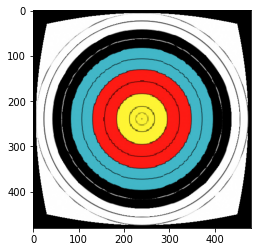

In [20]:
img3 = barrelDistCenter(target,1.2,0.7)
plt.imshow(img3)